#### Packages

In [2]:
import sys
import numpy as np
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

from pycbc import transforms
#sys.path.insert(0, "../data")
#from pycbc_draw_samples import read_config

import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import beta
import time

In [ ]:
# Packages
from pycbc.conversions import _mass2_from_mchirp_mass1
from pycbc.conversions import mass1_from_mchirp_eta, mass2_from_mchirp_eta

In [ ]:
from pycbc import distributions
from pycbc import conversions
from math import atan2,degrees

In [ ]:
from scipy.stats import halfnorm

### Uniform on Signal Duration

In [ ]:
def get_tau_priors(ml, mu, lf):
    # m2 will always be slightly lower than m1, but (m, m) will give limit
    # that the mchirp will never reach but tends to as num_samples tends to inf.
    # Range for mchirp can be written as --> (min_mchirp, max_mchirp)
    min_mchirp = (ml*ml / (ml+ml)**2.)**(3./5) * (ml + ml)
    max_mchirp = (mu*mu / (mu+mu)**2.)**(3./5) * (mu + mu)
    # Tau priors
    G = 6.67e-11
    c = 3.0e8
    tau = lambda mc: 5. * (8.*np.pi*lf)**(-8./3.) * (mc*1.989e30*G/c**3.)**(-5./3.)
    tau_lower = tau(max_mchirp)
    tau_upper = tau(min_mchirp)
    return (tau_lower, tau_upper)

In [ ]:
def get_uniform_masses(mass_lower, mass_upper, num_samples):
    # Get uniform mass distribution
    x_mass = [np.random.uniform(mass_lower, mass_upper, num_samples) for _ in range(2)]
    # Apply the mass constraint (mass2 <= mass1)
    masses = np.column_stack((x_mass[0], x_mass[1]))
    masses = np.fliplr(np.sort(masses, axis=1))
    # Sanity check
    assert all(masses[:,0] > masses[:,1]), "Mass1 > Mass2 in mass priors!"
    # Assign mass1 and mass2
    mass1 = masses[:,0]
    mass2 = masses[:,1]
    return (mass1, mass2)

In [ ]:
def q_from_mass1_mass2(mass1, mass2):
    # Calculate mass ratio (mass1/mass2) on bounds [1, +inf]
    return mass1/mass2

In [ ]:
def get_mchirp_priors(ml, mu):
    # m2 will always be slightly lower than m1, but (m, m) will give limit
    # that the mchirp will never reach but tends to as num_samples tends to inf.
    # Range for mchirp can be written as --> (min_mchirp, max_mchirp)
    min_mchirp = (ml*ml / (ml+ml)**2.)**(3./5) * (ml + ml)
    max_mchirp = (mu*mu / (mu+mu)**2.)**(3./5) * (mu + mu)
    return (min_mchirp, max_mchirp)

In [ ]:
num_samples = 100_000

In [ ]:
## Step 1a: Get uniform Tau values within bounds provided by m1 and m2
tau_lower, tau_upper = get_tau_priors(ml=7.0, mu=50.0, lf=20.0)
tau = np.random.uniform(tau_lower, tau_upper, num_samples)

In [ ]:
## Step 1b: Get uniform chirp mass and convert to tau
mchirp_lower, mchirp_upper = get_mchirp_priors(ml=7.0, mu=50.0)
expected_mchirp = np.random.uniform(mchirp_lower, mchirp_upper, num_samples)
G = 6.67e-11
c = 3.0e8
lf = 20.0
tau = 5. * (8.*np.pi*lf)**(-8./3.) * (expected_mchirp*1.989e30*G/c**3.)**(-5./3.)

In [ ]:
## Step 1c: Get power law chirp mass and convert to tau
mchirp_lower, mchirp_upper = get_mchirp_priors(ml=7.0, mu=50.0)
plaw_mchirp = (np.random.power(0.4, num_samples) * (mchirp_upper-mchirp_lower)) + mchirp_lower
assert min(plaw_mchirp) >= mchirp_lower
assert max(plaw_mchirp) <= mchirp_upper

G = 6.67e-11
c = 3.0e8
lf = 20.0
tau = 5. * (8.*np.pi*lf)**(-8./3.) * (plaw_mchirp*1.989e30*G/c**3.)**(-5./3.)

plt.figure(figsize=(6.0, 6.0))
plt.hist(plaw_mchirp, bins=100)
plt.xlabel('Chirp Mass')
plt.show()

plt.figure(figsize=(6.0, 6.0))
plt.hist(tau, bins=100)
plt.xlabel('Tau')
plt.show()

In [ ]:
## Step 1d: Get power law tau
# Go lower than 1.0 to bias toward lower values of tau
tau_lower, tau_upper = get_tau_priors(ml=7.0, mu=50.0, lf=20.0)
tau = (np.random.power(0.5, num_samples) * (tau_upper-tau_lower)) + tau_lower
assert min(tau) >= tau_lower
assert max(tau) <= tau_upper

plt.figure(figsize=(6.0, 6.0))
plt.hist(tau, bins=128)
plt.show()

In [ ]:
## Step 1e: Get halfnorm chirp mass and convert to tau
mchirp_lower, mchirp_upper = get_mchirp_priors(ml=7.0, mu=50.0)
hnorm_mchirp = halfnorm.rvs(size=1_000_000) * 10.0 + mchirp_lower
G = 6.67e-11
c = 3.0e8
lf = 20.0
tau = 5. * (8.*np.pi*lf)**(-8./3.) * (hnorm_mchirp*1.989e30*G/c**3.)**(-5./3.)

plt.figure(figsize=(6.0, 6.0))
plt.hist(hnorm_mchirp, bins=100)
plt.xlabel('Chirp Mass')
plt.show()

plt.figure(figsize=(6.0, 6.0))
plt.hist(tau, bins=100)
plt.xlabel('Tau')
plt.show()

In [ ]:
## Step 2: Find the intersection of const Tau curve on P(m1, m2) where m1, m2 are uniform and m1>m2

# Where does the curve intersect with m1=m2?
lf = 20.0 # Hz
G = 6.67e-11 # Nm^2/Kg^2
c = 3.0e8 # ms^-1
# tau = 5. * (8.*np.pi*lf)**(-8./3.) * (mchirp*1.989e30*G/c**3.)**(-5./3.)
# tau = C * mchirp**(-5./3.)
# tau = C * (m1+m2)^(1/3) / (m1m2)
# if m1=m2, tau = C * (2m)^(1/3) / m^2
# tau = C * 2^(1/3) * (m)^(1/3-2) = C' * m^(-5/3)
# m = (tau/C')^(-3./5.)
C = (5. * (8.*np.pi*lf)**(-8./3.)) * (1.989e30*G/c**3.)**(-5./3.)
C_1dash = C * 2**(1./3.)
intersc_diagonal = (tau/C_1dash)**(-3./5.)

# Where does the curve intersect with x or y axis?
# Where does it intersect m2 when m1=50.0 Msun?
# tau = C * (m1+m2)^(1/3) / (m1m2)
# (tau*50)/C = (50+m2)^(1/3) / m2
# (tau/C")^3 = (50+m2)/m2^3
# C"'*m2^3 = (50+m2)
# C"'m2^3 - m2 - 50 = 0 (coeff = C"', 0, -1, -50)
C_2dash = C/50.
C_3dash = (tau/C_2dash)**3.
# We get one non-complex root for the value of m2
m2_when_m1_is_mu = np.array([np.roots([c3d, 0.0, -1, -50]) for c3d in C_3dash])
m2_when_m1_is_mu = np.array([np.real(foo[np.isreal(foo)])[0] for foo in m2_when_m1_is_mu])

# Where does it intersect m1 when m2=7.0 Msun?
# tau = C * (m1+m2)^(1/3) / (m1m2)
# (tau*7)/C = (m1+7)^(1/3) / m1
# (tau/C"")^3 = (m1+7)/m1^3
# C""'*m1^3 = (m1+7)
# C""'m1^3 - m1 - 7 = 0 (coeff = C""', 0, -1, -7)
C_4dash = C/7.
C_5dash = (tau/C_4dash)**3.
# We get one non-complex root for the value of m2
m1_when_m2_is_ml = np.array([np.roots([c5d, 0.0, -1, -7]) for c5d in C_5dash])
m1_when_m2_is_ml = np.array([np.real(foo[np.isreal(foo)])[0] for foo in m1_when_m2_is_ml])

In [ ]:
## Step 3: We can get an upper and lower bound on m1. We can now sample uniformly on m1.
upper_bounds = m2_when_m1_is_mu
# Checkl if bounds are correct
idxs = m2_when_m1_is_mu < 7.0
alt_idxs = m2_when_m1_is_mu >= 7.0
upper_bounds[idxs] = m1_when_m2_is_ml[idxs]
upper_bounds[alt_idxs] = np.full(sum(alt_idxs), 50.0)

# Lower bounds
lower_bounds = intersc_diagonal
# Sampling uniformly on m1
# print(any([lower_bounds_i >= upper_bounds_i for lower_bounds_i, upper_bounds_i in zip(lower_bounds, upper_bounds)]))
mass1 = np.array([np.random.uniform(lb, ub) for lb, ub in zip(lower_bounds, upper_bounds)])

In [ ]:
## Step 4: Obtain m2 from m1 and const Tau.
# tau = C * (m1+m2)^(1/3) / (m1m2)
# C"""m2^3 - m2 - m1 = 0 (coeff = C""", 0, -1, -m1)
# C""" = (tau/(C/m1))^3
C_6dash = (tau/(C/mass1))**3.
mass2_roots = np.array([np.roots([c6d, 0.0, -1, -_m1]) for c6d, _m1 in zip(C_6dash, mass1)])
mass2 = np.array([np.real(foo[np.isreal(foo)])[0] for foo in mass2_roots])

In [ ]:
## Step 5: Obtain q and mchirp.
q = mass1/mass2
mchirp = (mass1*mass2 / (mass1+mass2)**2.)**(3./5) * (mass1 + mass2)

In [ ]:
# Plotting all distributions
bins = 128
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
ax[0][0].hist(q, bins=bins)
ax[0][0].set_xlabel('q')
ax[0][1].hist(mchirp, bins=bins)
ax[0][1].set_xlabel('mchirp')
ax[1][0].hist(mass1, bins=bins)
ax[1][0].set_xlabel('m1')
ax[1][1].hist(mass2, bins=bins)
ax[1][1].set_xlabel('m2')
ax[2][0].hist(tau, bins=bins)
ax[2][0].set_xlabel('tau')
ax[2][1].hist2d(mass1, mass2, bins=bins, norm=mpl.colors.LogNorm(), cmap=mpl.cm.cividis)
ax[2][1].set_xlabel('m1')
ax[2][1].set_ylabel('m2')
plt.show()

In [ ]:
plt.figure(figsize=(6.0, 6.0))
plt.hist2d(mchirp, q, bins=1024, norm=mpl.colors.LogNorm(), cmap=mpl.cm.cividis)
plt.show()

#### What if we sampled along a const Mc curve proportional to the length of the curve?

In [ ]:
# Will sampling more for longer curves ensure that we always sample more for lower chirp masses?
# If a const Mc curve in the given range is longer, it means that the Mc can be represented in more ways than one with a shorter length.
# More data and thus better interpolation might be required for a healthy representation of that const Mc
# In terms of sampling, this means that lower Mc curves are sampled more than higher Mc curves. So some power law on Mc.
# Or power law on tau with longer duration being higher than shorter durations.
# Okay, I've convinced myself that this isn't a waste of time.

In [ ]:
# What is the chirp mass of the longest curve?
tau = 2.5 # seconds
lf = 20.0 # Hz
G = 6.67e-11 # Nm^2/Kg^2
c = 3.0e8 # ms^-1
chirp_mass_from_tau = ((tau/5.) * (8.*np.pi*lf)**(8./3.))**(-3./5.) * (c**3./(G*1.989e30))
# This explains the difficulty of some of our runs to properly understand around this chirp mass
print(chirp_mass_from_tau)

In [ ]:
# Find the arc length of a cubic curve doesn't seem analytically trivial 
# We can try a brute force approximate method

class BoundedPriors:

    def __init__(self, mu, ml, lf):
        # Common
        self.lf = lf # Hz (signal low freq cutoff)
        self.mu = mu
        self.ml = ml
        # Constants
        G = 6.67e-11 # Nm^2/Kg^2
        c = 3.0e8 # ms^-1
        self.const = (5. * (8.*np.pi*lf)**(-8./3.)) * (1.989e30*G/c**3.)**(-5./3.)

    def _intersection_with_m1_eq_m2(self, tau):
        # Where does the curve intersect with m1=m2?
        C_1dash = self.const * 2**(1./3.)
        intersc_diagonal = (tau/C_1dash)**(-3./5.)
        return intersc_diagonal
    
    def _intersection_with_m2_when_m1_is_mu(self, tau):
        # Where does the curve intersect with x or y axis?
        # Where does it intersect m2 when m1=50.0 Msun?
        C_2dash = self.const/self.mu
        C_3dash = (tau/C_2dash)**3.
        # We get one non-complex root for the value of m2
        m2_when_m1_is_mu = np.array([np.roots([c3d, 0.0, -1, -self.mu]) for c3d in C_3dash])
        m2_when_m1_is_mu = np.array([np.real(foo[np.isreal(foo)])[0] for foo in m2_when_m1_is_mu])
        return m2_when_m1_is_mu

    def _intersection_with_m1_when_m2_is_ml(self, tau):
        # Where does it intersect m1 when m2=7.0 Msun?
        C_4dash = self.const/self.ml
        C_5dash = (tau/C_4dash)**3.
        # We get one non-complex root for the value of m2
        m1_when_m2_is_ml = np.array([np.roots([c5d, 0.0, -1, -self.ml]) for c5d in C_5dash])
        m1_when_m2_is_ml = np.array([np.real(foo[np.isreal(foo)])[0] for foo in m1_when_m2_is_ml])
        return m1_when_m2_is_ml
    
    def _get_m1_upper_bounds(self, m2_when_m1_is_mu, m1_when_m2_is_ml):
        upper_bounds = m2_when_m1_is_mu
        # Checkl if bounds are correct
        idxs = m2_when_m1_is_mu < self.ml
        alt_idxs = m2_when_m1_is_mu >= self.ml
        upper_bounds[idxs] = m1_when_m2_is_ml[idxs]
        upper_bounds[alt_idxs] = np.full(sum(alt_idxs), self.mu)
        return upper_bounds
    
    def _get_m2_from_m1_tau(self, mass1, tau):
        C_6dash = (tau/(self.const/mass1))**3.
        mass2_roots = np.array([np.roots([c6d, 0.0, -1, -_m1]) for c6d, _m1 in zip(C_6dash, mass1)])
        mass2 = np.array([np.real(foo[np.isreal(foo)])[0] for foo in mass2_roots])
        return mass2
    
    def _common_umc_utau(self, tau):
        ## Step 2: Find the intersection of const Tau curve on P(m1, m2) where m1, m2 are uniform and m1>m2
        intersc_diagonal = self._intersection_with_m1_eq_m2(tau)
        m2_when_m1_is_mu = self._intersection_with_m2_when_m1_is_mu(tau)
        m1_when_m2_is_ml = self._intersection_with_m1_when_m2_is_ml(tau)
        ## Step 3: We can get an upper and lower bound on m1. We can now sample uniformly on m1.
        upper_bounds = self._get_m1_upper_bounds(m2_when_m1_is_mu, m1_when_m2_is_ml)
        lower_bounds = intersc_diagonal
        mass1 = np.array([np.random.uniform(lb, ub) for lb, ub in zip(lower_bounds, upper_bounds)])
        ## Step 4: Obtain m2 from m1 and const Tau.
        mass2 = self._get_m2_from_m1_tau(mass1, tau)
        ## Step 5: Obtain q and mchirp.
        q = mass1/mass2
        mchirp = (mass1*mass2 / (mass1+mass2)**2.)**(3./5) * (mass1 + mass2)
        return (mass1, mass2, q, mchirp)

    def get_arc_length_given_tau(self, tau, num_pts):
        ## Step 2: Find the intersection of const Tau curve on P(m1, m2) where m1, m2 are uniform and m1>m2
        intersc_diagonal = self._intersection_with_m1_eq_m2(tau)
        m2_when_m1_is_mu = self._intersection_with_m2_when_m1_is_mu(tau)
        m1_when_m2_is_ml = self._intersection_with_m1_when_m2_is_ml(tau)
        ## Step 3: We can get an upper and lower bound on m1. We can now sample uniformly on m1.
        upper_bounds = self._get_m1_upper_bounds(m2_when_m1_is_mu, m1_when_m2_is_ml)[0]
        lower_bounds = intersc_diagonal[0]
        mass1 = np.linspace(lower_bounds, upper_bounds, num_pts)
        mass1.sort()
        ## Step 4: Obtain m2 from m1 and const Tau.
        mass2 = self._get_m2_from_m1_tau(mass1, tau)
        ## Step 5: Get Euclidean distance between consecutive m1, m2 coords
        coords = np.column_stack((mass1, mass2))
        euc_dist = lambda coord1, coord2: np.sqrt((coord2[0]-coord1[0])**2+(coord2[1]-coord1[1])**2)
        chunk_lengths = [euc_dist(coords[i], coords[i+1]) for i in range(len(coords)-1)]
        arc_length = np.sum(chunk_lengths)
        return arc_length
    
    def get_bounded_gwparams_from_importance_tau(self, num_samples=10_000):
        # Get tau from a beta distribution
        # Relative importance of const Tau line incorporated in this prior
        tau_lower, tau_upper = get_tau_priors(ml=self.ml, mu=self.mu, lf=self.lf)
        tau = beta.rvs(1.7, 5.25, size=num_samples) * (tau_upper - tau_lower) + tau_lower
        # Common steps
        mass1, mass2, q, mchirp = self._common_umc_utau(tau)
        return (mass1, mass2, q, mchirp, tau)

In [ ]:
plt.figure()
bp = BoundedPriors(mu=50.0, ml=7.0, lf=20.0)

In [ ]:
# Arc length for given tau
alt = lambda foo: np.array([foo]) # too lazy to change class
plt.figure()

for num_pts in [2, 3, 5, 10, 100, 1000]:
    start = time.time()
    arclens = []
    taus = np.linspace(0.5, 10.0, 1000)
    for _tau in taus:
        arclen = round(bp.get_arc_length_given_tau(alt(_tau), num_pts), 2)
        arclens.append(arclen)
        # print('arclen = {} for tau = {}'.format(arclen, _tau))
    end = time.time()
    time_taken = end - start
    print('Time taken for 1000 taus with {} pts = {} min and {} seconds'.format(num_pts, int(time_taken/60), round(time_taken%60., 3)))
    plt.plot(taus, arclens, label='{} pts for m1'.format(num_pts))

plt.xlabel('Tau')
plt.ylabel('Arc Lengths')
plt.xlim(1, 3)
plt.ylim(20.0, 36.0)
plt.grid()
plt.legend()
plt.show()

It's nice that we can get away with a relatively small number of points for estimating the arc length.

In [ ]:
def get_tau_priors(ml, mu, lf):
    # Range for mchirp
    min_mchirp, max_mchirp = get_mchirp_priors(ml, mu)
    # Tau priors
    G = 6.67e-11 # Nm^2/Kg^2
    c = 3.0e8 # ms^-1
    tau = lambda mc: 5. * (8.*np.pi*lf)**(-8./3.) * (mc*1.989e30*G/c**3.)**(-5./3.)
    tau_lower = tau(max_mchirp)
    tau_upper = tau(min_mchirp)
    return (tau_lower, tau_upper)

In [ ]:
# Arc length for given tau
alt = lambda foo: np.array([foo]) # too lazy to change class
tau_min, tau_max = get_tau_priors(7.0, 50.0, 20.0)
plt.figure()

for num_pts in [5]:
    start = time.time()
    arclens = []
    taus = np.linspace(tau_min, tau_max, 1000)
    for _tau in taus:
        arclen = round(bp.get_arc_length_given_tau(alt(_tau), num_pts), 2)
        arclens.append(arclen)
        # print('arclen = {} for tau = {}'.format(arclen, _tau))
    end = time.time()
    time_taken = end - start
    print('Time taken for 1000 taus with {} pts = {} min and {} seconds'.format(num_pts, int(time_taken/60), round(time_taken%60., 3)))
    plt.plot(taus, arclens, label='{} pts for m1'.format(num_pts))

plt.xlabel('Tau')
plt.ylabel('Arc Lengths')
plt.xlim(tau_min, tau_max)
plt.ylim(0.0)
plt.grid()
plt.legend()
plt.show()

We don't need all that many samples for the longest signal duration since it can only be produced by a single m1, m2 pair. This makes sense. The same is true for the shortest signal duration. Pairing this with a uniform signal duration prior might help the network obtain an unbiased representation as fast as possible. The sampling will be proportional to the "amount of information". 

In [ ]:
foo = beta.rvs(1.7, 5.25, size=1_000_000) * (tau_max - tau_min) + tau_min
plt.figure()
plt.hist(foo, bins=100, density=True)
plt.show()

In [ ]:
mass1, mass2, q, mchirp, tau = bp.get_bounded_gwparams_from_importance_tau(num_samples=1_000_000)

In [ ]:
# Plotting all distributions
bins = 1024
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
ax[0][0].hist(q, bins=bins)
ax[0][0].set_xlabel('q')
ax[0][1].hist(mchirp, bins=bins)
ax[0][1].set_xlabel('mchirp')
ax[1][0].hist(mass1, bins=bins)
ax[1][0].set_xlabel('m1')
ax[1][1].hist(mass2, bins=bins)
ax[1][1].set_xlabel('m2')
ax[2][0].hist(tau, bins=bins)
ax[2][0].set_xlabel('tau')
ax[2][1].hist2d(mass1, mass2, bins=bins, norm=mpl.colors.LogNorm(), cmap=mpl.cm.cividis)
ax[2][1].set_xlabel('m1')
ax[2][1].set_ylabel('m2')
plt.show()

In [ ]:
# Arc length for given mchirp
alt = lambda foo: np.array([foo]) # too lazy to change class
mchirp_min, mchirp_max = get_mchirp_priors(7.0, 50.0)
plt.figure()

for num_pts in [5]:
    start = time.time()
    arclens = []
    mcs = np.linspace(mchirp_min, mchirp_max, 1000) # thinking linear in mchirp instead of tau
    G = 6.67e-11
    c = 3.0e8
    lf = 20.0
    taus = 5. * (8.*np.pi*lf)**(-8./3.) * (mcs*1.989e30*G/c**3.)**(-5./3.)
    for _tau in taus:
        arclen = round(bp.get_arc_length_given_tau(alt(_tau), num_pts), 2)
        arclens.append(arclen)
    end = time.time()
    time_taken = end - start
    print('Time taken for 1000 mcs with {} pts = {} min and {} seconds'.format(num_pts, int(time_taken/60), round(time_taken%60., 3)))
    plt.plot(mcs, arclens, label='{} pts for m1'.format(num_pts))

plt.xlabel('Mc')
plt.ylabel('Arc Lengths')
plt.xlim(mchirp_min, mchirp_max)
plt.ylim(0.0)
plt.grid()
plt.legend()
plt.show()

#### Plotting altered distribution

In [ ]:
def labelLine(line,x,label=None,align=True,**kwargs):

    ax = line.axes
    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if (x < xdata[0]) or (x > xdata[-1]):
        print('x label location is outside data range!')
        return

    #Find corresponding y co-ordinate and angle of the line
    ip = 1
    for i in range(len(xdata)):
        if x < xdata[i]:
            ip = i
            break

    y = ydata[ip-1] + (ydata[ip]-ydata[ip-1])*(x-xdata[ip-1])/(xdata[ip]-xdata[ip-1])

    if not label:
        label = line.get_label()

    if align:
        #Compute the slope
        dx = xdata[ip] - xdata[ip-1]
        dy = ydata[ip] - ydata[ip-1]
        ang = degrees(atan2(dy,dx))

        #Transform to screen co-ordinates
        pt = np.array([x,y]).reshape((1,2))
        trans_angle = ax.transData.transform_angles(np.array((ang,)),pt)[0]

    else:
        trans_angle = 0

    #Set a bunch of keyword arguments
    if 'color' not in kwargs:
        kwargs['color'] = line.get_color()

    if ('horizontalalignment' not in kwargs) and ('ha' not in kwargs):
        kwargs['ha'] = 'center'

    if ('verticalalignment' not in kwargs) and ('va' not in kwargs):
        kwargs['va'] = 'center'

    if 'backgroundcolor' not in kwargs:
        kwargs['backgroundcolor'] = ax.get_facecolor()

    if 'clip_on' not in kwargs:
        kwargs['clip_on'] = True

    if 'zorder' not in kwargs:
        kwargs['zorder'] = 2.5

    ax.text(x,y,label,rotation=trans_angle,**kwargs)

def labelLines(lines,align=True,xvals=None,**kwargs):

    ax = lines[0].axes
    labLines = []
    labels = []

    #Take only the lines which have labels other than the default ones
    for line in lines:
        label = line.get_label()
        if "_line" not in label:
            labLines.append(line)
            labels.append(label)

    if xvals is None:
        xmin,xmax = ax.get_xlim()
        xvals = np.linspace(xmin,xmax,len(labLines)+2)[1:-1]

    for line,x,label in zip(labLines,xvals,labels):
        labelLine(line,x,label,align,**kwargs)

In [ ]:
_m1 = mass1
_m2 = mass2
ml, mu = (7.0, 50.0)

plt.figure(figsize=(7.0, 6.0), dpi=300)
mchirp = (_m1*_m2 / (_m1+_m2)**2.)**(3./5) * (_m1 + _m2)
# cmap_custom = LinearSegmentedColormap.from_list('', ['white', *plt.cm.cividis(np.arange(255))])

#plt.scatter(_m1, _m2, s=0.01, c=mchirp, cmap='cividis')
plt.hist2d(_m1, _m2, cmap='cividis', bins=1024, norm=mpl.colors.LogNorm())

# Get mchirp from given tau
tau = [0.5, 1.0, 2.0, 4.0]
print('tau = {}'.format(tau))
lf = 20.0 # Signal low frequency cutoff
G = 6.67e-11
c = 3.0e8
mchirp_from_tau = lambda tau: (((5. * (8.*np.pi*lf)**(-8./3.))/tau)**(3./5.))/(1.989e30*G/c**3.)
mchirp_line = [mchirp_from_tau(_tau) for _tau in tau]

# mchirp curve on m1, m2 plot
print('mchirp line at = {}'.format(mchirp_line))
for _mc, _tau in zip(mchirp_line, tau):
    m1_line = np.linspace(ml, mu, 1000)
    m2_line = [_mass2_from_mchirp_mass1(mchirp=_mc, mass1=m1i) for m1i in m1_line]
    plt.plot(m1_line, m2_line, c='k', label=r'$\tau={}s$'.format(_tau))

labelLines(plt.gca().get_lines(), xvals=(41.8, 26.6, 16.55, 10), zorder=2.5, fontsize=12)

# We change the fontsize of minor ticks label 
fontsize = 14
plt.tick_params(axis='both', which='major', labelsize=fontsize)

plt.xlim(ml, mu)
plt.ylim(ml, mu)
plt.xlabel(r'$\mathregular{m_1} \; (\mathrm{M}_\odot)$', fontsize=fontsize)
plt.ylabel(r'$\mathregular{m_2} \; (\mathrm{M}_\odot)$', fontsize=fontsize)
cbar = plt.colorbar(fraction=.05, pad=0.05)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label('Number of Samples', size=fontsize)
plt.tight_layout()
plt.savefig('./paper/testing_dataset_priors.png')

### Experimenting with Tau0 and Tau3 joint distribution for ORChiD priors

In [ ]:
# Defining Tau0 and Tau3
fl = 20.0 # Hz (signal low freq cutoff)
G = 6.67e-11 # Nm^2/Kg^2
c = 3.0e8 # ms^-1
A0 = 5./(256.*(np.pi*fl)**(8./3.))
tau0_given_mc = lambda Mc: A0 * (Mc*1.989e30*G/c**3.)**(-5./3.)

In [ ]:
# Get Mc bounds and use that to get bounds on tau0
ml = 7.0 # Msun
mu = 50.0 # Msun
min_mchirp = (ml*ml / (ml+ml)**2.)**(3./5) * (ml + ml)
max_mchirp = (mu*mu / (mu+mu)**2.)**(3./5) * (mu + mu)
# Bounds on Tau0
min_tau0 = tau0_given_mc(min_mchirp)
max_tau0 = tau0_given_mc(max_mchirp)

In [ ]:
# Tau3 when Tau0 is given
# x^3 - px + q = 0 (where x=M^1/3, p=-A0/(tau0/me) and q=-me)
# We will sample uniformly on tau0, me is constant and we get the roots for x
# We can get M from x and apply it to tau3 = (A3/A0)*tau0*M to get tau3 at boundaries
# tau3 = 4*A3*(tau0/4A0)**(2./5.) when eta = 0.25 at m1=m2
# Once we get boundaries on tau3 given tau0, we can sample uniformly on tau0 to get tau3 within bounds

## Sample uniformly on tau0
num_samples = 10_000
tau0 = np.random.uniform(min_tau0, max_tau0, num_samples)

## Boundaries of tau3 given tau0


In [ ]:
# Once we get points in the tau0, tau3 joint distribution, we can convert this to m1, m2
pass

In [ ]:
# Plotting the distributions
# Hopefully a distribution that is uniform on tau0, tau3 space will translate to what we need on Mc, q
pass

### Experimenting with joint distributions

In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.append('/home/nnarenraju/Research/ORChiD/DEBUGGING/ML-GWSC1-Glasgow/source/baseline/utils')
from get_testdata_snr import get_snrs
#sys.path.append("/home/nnarenraju/Research/ORChiD/DEBUGGING/ML-GWSC1-Glasgow/source/baseline")
#from data_configs import Default as data_cfg

In [ ]:

names = ['mass1', 'mass2', 'ra', 'dec', 'inclination', 'coa_phase', 'polarization',
        'chirp_distance', 'spin1_a', 'spin1_azimuthal', 'spin1_polar', 'spin2_a',
        'spin2_azimuthal', 'spin2_polar', 'injection_time', 'tc', 'spin1x', 'spin1y',
        'spin1z', 'spin2x', 'spin2y', 'spin2z', 'mchirp', 'q', 'distance']

mpnames = {name:n for n, name in enumerate(names)}

In [ ]:
injections_file = "/local/scratch/igr/nnarenraju/injections_plots/injections.hdf"
with h5py.File(injections_file, "r") as foo:
    # Attributes of file        
    injections = np.asarray(foo['data'])
    injections = np.asarray([list(foo) for foo in injections])
    print(injections.shape)
    check = injections[:, mpnames[check_param]]
    param = {name: injections[:, mpnames[name]] for name in names}

In [ ]:
""" 
snrs = get_snrs("/local/scratch/igr/nnarenraju/dataset_D4_2e6_Nov05_seed42/injections/injections.hdf", data_cfg)
 
with h5py.File("snr.hdf", 'a') as ds:
    ds.create_dataset('snr', data=snrs)
"""

In [ ]:

snrs_path = "/local/scratch/igr/nnarenraju/injections_plots/snr.hdf"
if os.path.exists(snrs_path):
    with h5py.File(snrs_path, 'r') as fp:
        snrs = fp['snr'][()]

param['snr'] = snrs
idx = np.argwhere(snrs < 100.0).flatten()

In [ ]:
lf = 20.0 # Hz
G = 6.67e-11 # Nm^2/Kg^2
c = 3.0e8 # ms^-1
param['tau'] = 5. * (8.*np.pi*lf)**(-8./3.) * (param['mchirp']*1.989e30*G/c**3.)**(-5./3.)

In [ ]:
check_param = 'snr'
check = injections[:, mpnames[check_param]] if check_param != 'snr' else snrs

In [ ]:
plt.figure()
plt.hist(snrs[idx], bins=128)
plt.vlines(np.mean(snrs[idx]), 0, 100_000, colors='k')
plt.xlabel('Optimal network SNR')
plt.ylim(0, 75000)
plt.grid()
plt.show()

In [ ]:
fig, axs = plt.subplots(6, 5, figsize=(36, 30))
pidxs = np.dstack(np.indices((6, 5))).reshape(30, 2)
for n, name in enumerate(param.keys()):
    i = pidxs[n][0]
    j = pidxs[n][1]
    axs[i][j].hist2d(check[idx], param[name][idx], bins=256, cmap=mpl.cm.Blues)
    axs[i][j].set_xlabel(check_param)
    axs[i][j].set_ylabel(name)

for foo in pidxs[len(param.keys()):]:
    i, j = foo
    axs[i][j].set_visible(False)
plt.show()

In [ ]:
check_param = 'mchirp'
check = injections[:, mpnames[check_param]] if check_param != 'snr' else snrs

fig, axs = plt.subplots(6, 5, figsize=(36, 30))
pidxs = np.dstack(np.indices((6, 5))).reshape(30, 2)
for n, name in enumerate(param.keys()):
    i = pidxs[n][0]
    j = pidxs[n][1]
    axs[i][j].hist2d(check[idx], param[name][idx], bins=256, cmap=mpl.cm.Blues)
    axs[i][j].set_xlabel(check_param)
    axs[i][j].set_ylabel(name)

for foo in pidxs[len(param.keys()):]:
    i, j = foo
    axs[i][j].set_visible(False)
plt.show()

### SNR distributions

In [1]:
import numpy as np
from scipy.stats import halfnorm
import matplotlib.pyplot as plt

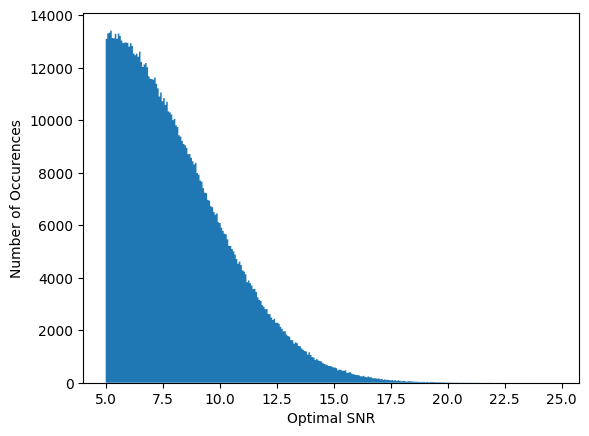

In [2]:
fig, ax = plt.subplots(1, 1)
r = halfnorm.rvs(size=1_000_000) * 4.0 + 5.0
ax.hist(r, bins='auto', histtype='stepfilled')
ax.set_xlabel('Optimal SNR')
ax.set_ylabel('Number of Occurences')
plt.show()

In [ ]:
r = halfnorm.rvs() * 4.0 + 5.0
print(r)

In [2]:
# SNR as a function of chirp mass
lowest_mc_snr_mean = 10.0
highest_mc_snr_mean = 7.0

In [25]:
# Chirp mass limits
ml = 7.0 # Msun
mu = 50.0 # Msun
min_mchirp = (ml*ml / (ml+ml)**2.)**(3./5) * (ml + ml)
max_mchirp = (mu*mu / (mu+mu)**2.)**(3./5) * (mu + mu)

In [27]:
# Get line params
slope = (highest_mc_snr_mean-lowest_mc_snr_mean)/(max_mchirp-min_mchirp)
const = lowest_mc_snr_mean - (slope*min_mchirp)
mean_snr_given_mc = lambda mc: slope * mc + const

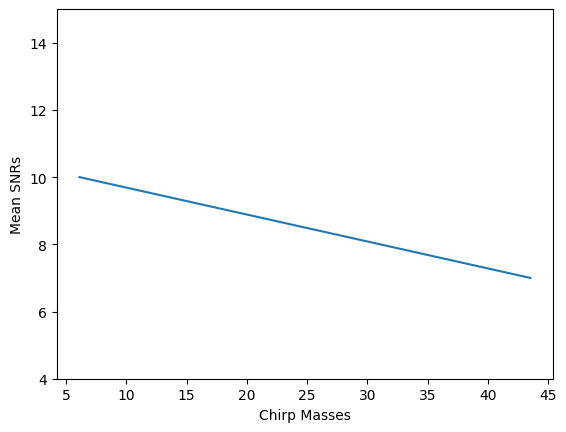

In [30]:
# Plot line
chirp_masses = np.linspace(min_mchirp, max_mchirp, 1000)
mean_snrs = np.array([mean_snr_given_mc(foo) for foo in chirp_masses])
plt.plot(chirp_masses, mean_snrs)
plt.ylabel('Mean SNRs')
plt.xlabel('Chirp Masses')
plt.ylim(4.0, 15.0)
plt.show()

31965


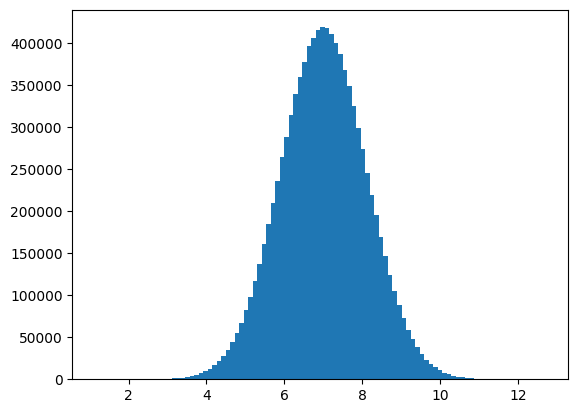

In [24]:
foo = np.random.normal(loc=7.0, scale=1.1, size=10_000_000)
print(len(foo[foo<4.0]))
plt.hist(foo, bins=100)
plt.show()

In [32]:
foo = np.random.normal(loc=7.0, scale=1.1)
print(foo)

7.182751727923688


In [12]:
G = 6.67e-11
c = 3.0e8
lf = 20.0
tau = lambda mc: 5. * (8.*np.pi*lf)**(-8./3.) * (mc*1.989e30*G/c**3.)**(-5./3.)
print('tau = {} seconds'.format(tau(8.5)))

tau = 6.226214698954075 seconds
